In [71]:
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd

In [72]:

def get_mask(image):
    image = image.astype(np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    binr = cv2.threshold(gray, 16, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    binr = np.invert(binr)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(binr, kernel, iterations=3)
    mask = (mask // 255).astype(np.uint8)
    return mask

def process_image(image):
    rgb_image = image.astype(np.uint8)
    mask = get_mask(rgb_image)
    gray = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    rgb_planes = cv2.split(rgb_image)
    result_planes = []
    for plane in rgb_planes:
        processed_image = cv2.medianBlur(plane, 7)
        processed_image = cv2.bitwise_and(processed_image, processed_image, mask=mask)
        result_planes.append(processed_image)
    result = cv2.merge(result_planes)
    return result

def process_label(image, label):
    mask = get_mask(np.array(image))
    mask = mask.astype(np.uint8)
    moisture = np.zeros_like(mask, dtype=np.float32)
    ph = np.zeros_like(mask, dtype=np.float32)
    moisture_value = label[0] *10
    ph_value = label[1]
    moisture[mask == 1] = moisture_value
    ph[mask == 1] = ph_value
    return moisture, ph

def mask_labels(mask, label):
    channel_0 = cv2.bitwise_and(label[0][0], label[0][0], mask=mask)
    channel_1 = cv2.bitwise_and(label[1][0], label[1][0], mask=mask)
    return [channel_0, channel_1]

def unprocess_label(label):
    label = np.array(label, dtype=float)
    label_0_flat = label[0].flatten()
    label_1_flat = label[1].flatten()
    filtered_label_0 = label_0_flat[label_0_flat != 0]
    filtered_label_1 = label_1_flat[label_1_flat != 0]
    moisture = filtered_label_0 / 10
    ph = filtered_label_1
    return [np.mean(moisture), np.mean(ph)]

def unprocess_label_wmask(image, label):
    
    def make_mask(image):
        image = np.array(image, dtype=np.uint8)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        mask = (gray > 0).astype(np.uint8)
        return mask

    unnormalized_image = np.array(image * 255).astype(np.uint8)
    mask = make_mask(unnormalized_image)

    # Mask the labels
    masked_labels = mask_labels(mask, label)
    results = unprocess_label(masked_labels)
    return results

def huber_ph(y_true, y_pred, delta=1):
    y_pred = tf.cast(y_pred, dtype=K.floatx())
    y_true = tf.cast(y_true, dtype=K.floatx())
    
    # # Create mask based on non-zero values of y_true
    # mask = tf.cast(y_true != 0, y_pred.dtype)
    
    # # Apply mask to y_true and y_pred
    # y_true = y_true * mask
    # y_pred = y_pred * mask
    
    delta = tf.cast(delta, dtype=K.floatx())
    error = tf.subtract(y_pred, y_true)
    abs_error = tf.abs(error)
    half = tf.convert_to_tensor(0.5, dtype=abs_error.dtype)
    return K.mean(
        tf.where(
            abs_error <= delta,
            half * tf.square(error),
            delta * abs_error - half * tf.square(delta),
        ),
        axis=None,
    )
def huber_moisture(y_true, y_pred, delta=5):
    y_pred = tf.cast(y_pred, dtype=K.floatx())
    y_true = tf.cast(y_true, dtype=K.floatx())
    
    # # Create mask based on non-zero values of y_true
    # mask = tf.cast(y_true != 0, y_pred.dtype)
    
    # # Apply mask to y_true and y_pred
    # y_true = y_true * mask
    # y_pred = y_pred * mask
    
    delta = tf.cast(delta, dtype=K.floatx())
    error = tf.subtract(y_pred, y_true)
    abs_error = tf.abs(error)
    half = tf.convert_to_tensor(0.5, dtype=abs_error.dtype)
    return K.mean(
        tf.where(
            abs_error <= delta,
            half * tf.square(error),
            delta * abs_error - half * tf.square(delta),
        ),
        axis=None,
    )
    
    import tensorflow as tf
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    # y_pred = tf.convert_to_tensor(y_pred)
    # y_true = tf.cast(y_true, y_pred.dtype)
    
    y_pred = tf.cast(y_pred, dtype=K.floatx())
    y_true = tf.cast(y_true, dtype=K.floatx())

    # # Create mask based on non-zero values of y_true
    # mask = tf.cast(y_true != 0, y_pred.dtype)
    
    # # Apply mask to y_true and y_pred
    # y_true = y_true * mask
    # y_pred = y_pred * mask
    
    return K.sqrt(K.mean(tf.square(y_pred - y_true), axis=None))

def mean_squared_error(y_true, y_pred):
    # y_pred = tf.convert_to_tensor(y_pred)
    # y_true = tf.cast(y_true, y_pred.dtype)
    
    y_pred = tf.cast(y_pred, dtype=K.floatx())
    y_true = tf.cast(y_true, dtype=K.floatx())

    # # Create mask based on non-zero values of y_true
    # mask = tf.cast(y_true != 0, y_pred.dtype)
    
    # # Apply mask to y_true and y_pred
    # y_pred = y_pred * mask
    # y_true = y_true * mask
    
    return K.mean(tf.math.squared_difference(y_pred, y_true), axis=None)

def mean_absolute_error(y_true, y_pred):
    # y_pred = tf.convert_to_tensor(y_pred)
    # y_true = tf.cast(y_true, y_pred.dtype)
    
    y_pred = tf.cast(y_pred, dtype=K.floatx())
    y_true = tf.cast(y_true, dtype=K.floatx())

    # # Create mask based on non-zero values of y_true
    # mask = tf.cast(y_true != 0, y_pred.dtype)
    
    # # Apply mask to y_true and y_pred
    # y_pred = y_pred * mask
    # y_true = y_true * mask
    
    return K.mean(tf.abs(y_pred - y_true), axis=None)


In [73]:
custom_objects = {
            'root_mean_squared_error': root_mean_squared_error,
            'mean_absolute_error': mean_absolute_error,
            'huber_ph': huber_ph,
            'huber_moisture': huber_moisture
            }
modelB = tf.keras.models.load_model(filepath="design_models_v2\\designB_v37\\designB_v0.h5", custom_objects=custom_objects)

In [74]:
test = pd.read_csv('.\\test_data_v4.csv',  names=["path","value"])
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1/255.
    ).flow_from_dataframe(
    test, 
    x_col="path", 
    y_col="value", 
    class_mode='raw', 
    batch_size=198,
    target_size=(64,64),
    shuffle=False
    )

Found 20 validated image filenames.


c:\Users\nealb\AppData\Local\miniconda3\envs\pd\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


# Base64

In [75]:
TEST_DATA = next(val_generator)

In [76]:
TEST_DATA[0][0].shape

(64, 64, 3)

In [77]:
import numpy as np
from PIL import Image
import io
import base64

def encode_image(image):
    array = np.array(image).astype(np.uint8)
    image = Image.fromarray(array)
    buffer = io.BytesIO()
    image.save(buffer, format="JPEG")
    image_bytes = buffer.getvalue()
    image_base64 = base64.b64encode(image_bytes).decode("utf-8")
    return image_base64


In [78]:
print(encode_image(TEST_DATA[0][0]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0IMfSkyeoJ4qO/vbfT7C6u5W/d20bSSBeSABn88V4p40+IEviLZZWCvBp6nLqxG+Y543Y7Djj15OeMd1SooImMGz0fW/iDoWiOYpbprqbfsaK1Acpxzk5A9uuc9utcHrHxV1G6e5g02JLeEyDy3kH7xUA5B7ZPt0yee488/iO

In [79]:
print(encode_image(TEST_DATA[0][1]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0QSn1ppncHIwcdqiug0EQkii80qwyu/bhc4J98DJx3x261n297NaWN5e61LHbwrIZEBAHlRYG1TgnLZzn1YkDjFei2kZpGm80j9BgUqLnqa8f8SeP7rU2kgs99tZ8jg/PIP8AaPbp0Hr34rQ+FN9crq93ZPNttDAZBCT/AB7l

In [80]:
print(encode_image(TEST_DATA[0][2]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDtyxPQVGwYfdGB71jeLNfTw3orTiSL7W7BYYnJO/kbsY9u54BIz6Hx3UvF2u6sjR3OoOYm6ooCA4BGOMcfMR79+gr06uIjTduplGm5Hs9/4g0+w0x76a7haAZVfLcMXYfwqM8n/wDX0rNtPGug30kUf25YXcBtkyMm3IzyxGPx

In [81]:
print(encode_image(TEST_DATA[0][3]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDv2bihCT6AVzmu+MdJ0aKB3mS5M5PlrC4bgZyxx2yCO+SDxwa86b4i6h/ZF7buxNzPKzwSgkNbqWOQDyTwSBjGPU8Ad860IOzM402z2WO7gmuZbQODPEqtIgB+UNnH57T+XvUgiGflr5s1DWNUv2ia7vZ7hYsqgdy5GeTye/8A

In [82]:
print(encode_image(TEST_DATA[0][4]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDtgBjLHn0o56jk1HOEggaeSRVWMF3ZzgBQMnnt9a8p1f4j6jLcTw6U6RQCZtkwQszpng/P0/ADt6V61atCkryOOlTlUeh3HiXxOdAurGN4leOZmMvPzKox0Hrzn8CO+Rx2pfE2+ud0GnwLaBsYmkIJA5zwRj+79OeeeOM1LVL3

In [83]:
print(encode_image(TEST_DATA[0][5]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDsiGGcHntmsfxBr9rothO73EIuliLxQMwLMegO3IJGev41q3NxDa27zXEyQxL1kdgoGTgcnjrXhPi3V5Na1+5mcKyo5hh2jjy1Y46dc5J5z19MV6OIrezjpuzOlDnZFea/qt+37y9uGVZjNGDLyCehHuPbAHOMZNMsNc1Kwumu

In [84]:
print(encode_image(TEST_DATA[0][6]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDu2vFQ4GWPtUFxqYRGZ5UijUEszEAAAZOSfYGuP8WeK4NGhurO0nU6koVdpQjyywznJBUnBBwePr0ry251HU9TVvtF5M8bMWKvISC3qB0Hp/8AW4r0K2KhTdlqZU6Epq70PfLvU4NPtGuruYRwrgFtpPU4HA571JDdQXkKzW0q

In [85]:
print(encode_image(TEST_DATA[0][7]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDusnHU0ea6r94/lmmCZW7Vi634l0/RoVa7nCCTOwKCWbHXGP59K9mTSV2cSTbsjTu7uO2gaa4mSOJerSMFA7Dk+9LFPHLEs0MqyRsMq6EEH6GvCte8V6hrV5JIu9YGACwLIxTg5BI7n39qf4f8X6ppVq9rBMjpKGIV0z5bEfeH

In [86]:
print(encode_image(TEST_DATA[0][8]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDvDKexphdjnLVX1C9tNLsJr27mENvEMuxBOOw4HXk15HrPxM1W+ikhs0js4nbAMfzSAYwQWPr1yACPWvUqVoU9zCFNz2O21f4g6PpUzQq73sgXObfayA9gTn+WaxZPimquvk6QzrwWzNz05Awvr37gdBnjzHg/vAcbupHGaYpw

In [87]:
print(encode_image(TEST_DATA[0][9]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDv6a6g024nitYWmnkSKJeWd2CgfUmud1Lx3oWnOsZuTcs3UWwDhR6k5x+RzXqynGOrZgot7Gpf6zpmmOkV7ewwu4yEduSPXHpweao2Op2GrJLJptyJhG2GwCCPTg849/avKPG+q2+q+I5Z7O6EkJRVG5SAeO3f/wCvVvw/4wt/

In [88]:
print(encode_image(TEST_DATA[0][10]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0Eg1z2teNNG0OZoLu5Y3CgHykQk8nHXp+val8ZeI18O6C9yEMksp8mLbnAYg8kjkAYPTn+deAgAqSwyTwA1dVevyaLcmnS5tWezz/ABP8PiymkiaaS4RQUgZCpckDjPIGM4J9jjPGcSz+LKBZ/telsuBmLy5OrYHByPXJyOnA

In [89]:
print(encode_image(TEST_DATA[0][11]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDvSPSoLm7hs7d57meOCFMbpJHCqMnAyT71g+J/Gdh4ftmUSCa9dWEUSYYBhkAtyMDcMHv19DXjF5repX7XH2q7llMzZlJAG/nIB9QMZA6DsK9CriYw0WrMoUXLU9if4h+HFaIf2gziQ9Vhf5Rzy2RkdMevI4xzUH/CyfD4uZ0M

In [90]:
print(encode_image(TEST_DATA[0][12]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDtY5nQZ3Z9c0PfyfdXAP0qld3cFrEZJZY4ox1d2AUfia4zU/iFaWl61taW7XK7M+asm0Z9htPT1PfNevUqQhrJnLCnKWx3Ymkc/M3HtWJd+L9I07VXsLmWQTKAXcL8q5GQPUnGOg7153rPjvU9Q3LayfY4wykCJyGyAc5YYODn

In [91]:
print(encode_image(TEST_DATA[0][13]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDvyW6DpUfnOvKnK1KV3Drx7VzOv+MtK8PyzW80rS3aIHEMZzknPBP8PTJz2IIzXpSlGKuzFRctjekncgl2CqBknpSRzxyQLKsiPEwDLIpGGB6EHpXiviHx1rOuwS26LDDZv1gUAlhuyMsecjA5GOnTnFYT6vqZ01bGaeT7LExd

In [92]:
print(encode_image(TEST_DATA[0][14]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDrWlnTlR71l6v4jj0eFHv7lIFkJCfLlmx1wBVXxd4jh8PaYwjkVr+VSsKDGU4PzkHsMfiePWvFrm4lu7mW4uGMk0shkZmGMknJOPqfSvRr4tU/ditTClQ5tXseg3HxNhR2FtYySOcBWlfbzg9QM+3f8qt6X8TbJ7gR39nJbqxA

In [93]:
print(encode_image(TEST_DATA[0][15]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDvVkdeN5/Ghrryx6n61n6zrFjounPe3jhY14UfxO3ZQO5rybX/AB1da3ay2QSOK2eVgGC/MyZ+QHk4IxkkHr7dfRq1oU99zGFOUtj1bVNeg0y2a4vLiOGNRuOQScZC5wOerL0Hen2N/bapbJc28yzQt0ZT3/p9K+eDdSv8hkdg

In [94]:
print(encode_image(TEST_DATA[0][16]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDvcyNyCabhxknJqY/KK4b4i69c6ba2UNrLJAskhMk0bFSMDhcjsc5/4DXrVKihFyZxwpuUkjsSz5xjNAUkZxg+leN6b481bT5ZJFuDdK+FZLhmfHoRzkH/AB+ldXqHxHWPT9NuLO1WSSZytyHBAjKgZXI6ZzkHngdCeBzwxdOS

In [95]:
print(encode_image(TEST_DATA[0][17]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDsQoPvShip+Xge1IVPqBVXUL2HTLOW5uJAqIrMBuAZ8KTtXJGTgHivbbS1ZwpNlp5pW6HH0rmNW8aWGntLFG4up0hE4CSAIw3AEbhn5gPmxjpXHz/Ea8lm1ALDHLZT5SFMhWiXOMkjPJGeucHB6DFcI4zMQJZME9DkgA9uODXD

In [96]:
print(encode_image(TEST_DATA[0][18]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDujkc457UbQByMml24PX3rjvGHjiPw862dqsU96RlkZjiEcY3AdcjPGR2Ppn2JzUFdnHGLk7I6yWdLWCSeV9kUal3Y9AAMk1V/tbTzDFcHULbypuInMy4fnHBzzzXleo/EC61zQp9MureGCS4I/wBKjZgqKCDgpyT0OSD0PQ45

In [97]:
print(encode_image(TEST_DATA[0][19]))

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABAAEADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD0Az1G020ZLflUHzY6iomKZJYjAGSSe1ezY4tSwJHfkEAUjORXODxpoZ0yO/e9EMTyeUA6ncHABI2jJ4BHI45HNVLfx3o1zPcR+bLGkIJMsifK2GC8YyeSR26Vk6tPuaKnPsdcHyOtHmkcE1w9946jstZa3WETWaKCZY3BLZAI

# Test

In [98]:
Xs_TEST = []
Ys_TEST = []
X_train = []
X_test = []
y_train = []
y_test = []
x,y = next(val_generator)
Xs_TEST.extend([np.array(value).astype(int) for value in x])
Ys_TEST.extend([np.array(value.replace("'","")[1:-1].split(', ')).astype(float) for value in y])

In [99]:
for i, x in enumerate(Xs_TEST):
    y_test.append(process_label(Xs_TEST[i], Ys_TEST[i]))
    X_test.append(process_image(Xs_TEST[i]))

In [100]:
from tensorflow.keras.utils import Sequence
class MultiOutputDataGenerator(Sequence):
    def __init__(self, X, y, batch_size, rescale=None):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.rescale = rescale
        self.indexes = np.arange(len(X))

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = np.array([self.X[i] for i in batch_indexes])
        batch_y = [np.array([self.y[i][0] for i in batch_indexes]),  # Moisture
                   np.array([self.y[i][1] for i in batch_indexes])]  # pH

        if self.rescale:
            batch_X = batch_X * self.rescale

        return batch_X, {'moisture_output': batch_y[0], 'ph_output': batch_y[1]}

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

In [101]:
val_generator = MultiOutputDataGenerator(X_test, y_test, batch_size=4, rescale=1./255)

val_gen_iter = iter(val_generator)

In [102]:
X_values_2,y_values_2 = [],[]
SAMPLE = []
SAMPLE_Y = []
for i in range(5):
    values = next(val_gen_iter)
    X_values_2.append(values[0])
    y_values_2.append(list(zip(values[1]["moisture_output"], values[1]["ph_output"])))
    SAMPLE.extend(values[0])
    SAMPLE_Y.extend(list(zip(values[1]["moisture_output"], values[1]["ph_output"])))
    
SAMPLE_Y = np.array(SAMPLE_Y)

SAMPLE_Y = SAMPLE_Y[:, :, np.newaxis, :, :, np.newaxis]

1/1 [==============================] - 0s 22ms/step


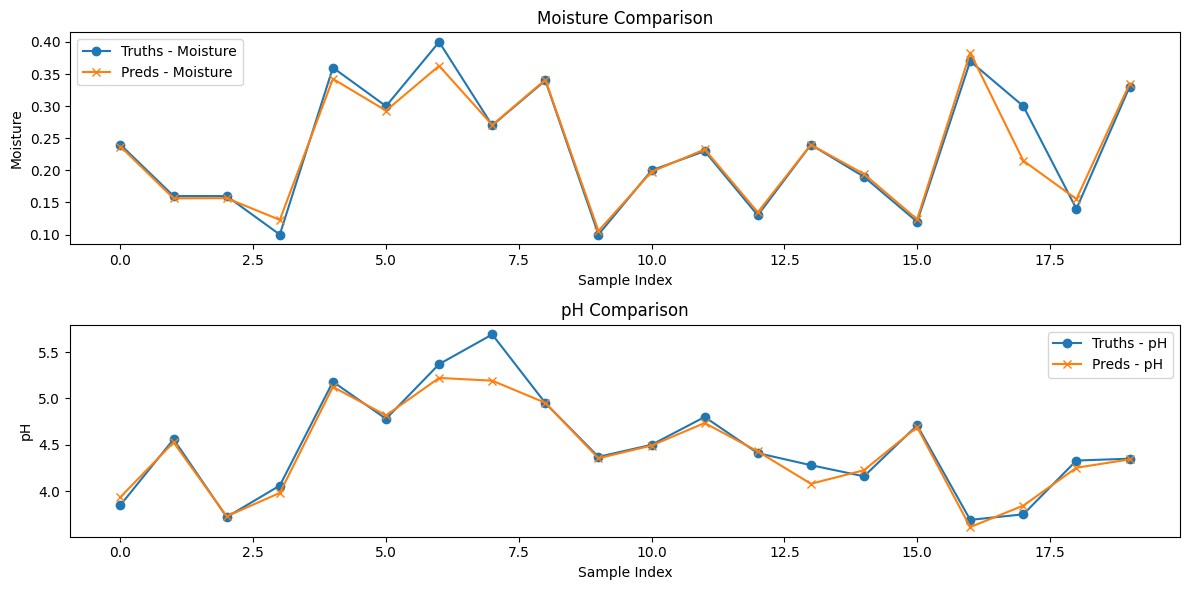

94.67209092900413
98.29370551290776
Moisture Truth
0.240
0.160
0.160
0.100
0.360
0.300
0.400
0.270
0.340
0.100
0.200
0.230
0.130
0.240
0.190
0.120
0.370
0.300
0.140
0.330
Moisture Pred
0.237
0.157
0.157
0.123
0.343
0.293
0.363
0.271
0.341
0.106
0.198
0.233
0.135
0.240
0.194
0.124
0.383
0.215
0.155
0.335
ph Truth
3.85
4.56
3.72
4.06
5.18
4.78
5.37
5.69
4.95
4.37
4.50
4.80
4.41
4.28
4.16
4.71
3.69
3.75
4.33
4.35
ph Pred
3.94
4.53
3.73
3.98
5.12
4.82
5.22
5.19
4.95
4.35
4.49
4.74
4.43
4.08
4.23
4.69
3.61
3.84
4.25
4.34


In [103]:
import matplotlib.pyplot as plt
truths = []
preds = []
raw_preds = []
for i in range(20):
    predictions = modelB.predict(np.array([SAMPLE[i]]))
    raw_preds.append(predictions)
    truths.append(unprocess_label_wmask(SAMPLE[i],SAMPLE_Y[i]))
    preds.append(unprocess_label_wmask(SAMPLE[i],predictions))
truths_moisture = [truth[0] for truth in truths]
truths_ph = [truth[1] for truth in truths]
preds_moisture = [pred[0] for pred in preds]
preds_ph = [pred[1] for pred in preds]

plt.figure(figsize=(12, 6))

# Moisture Plot
plt.subplot(2, 1, 1)
plt.plot(truths_moisture, label='Truths - Moisture', marker='o')
plt.plot(preds_moisture, label='Preds - Moisture', marker='x')
plt.title('Moisture Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Moisture')
plt.legend()

# pH Plot
plt.subplot(2, 1, 2)
plt.plot(truths_ph, label='Truths - pH', marker='o')
plt.plot(preds_ph, label='Preds - pH', marker='x')
plt.title('pH Comparison')
plt.xlabel('Sample Index')
plt.ylabel('pH')
plt.legend()

plt.tight_layout()
plt.show()

def accuracy(truth, pred):
    return (1 - abs(truth - pred) / truth) * 100

TEMP_0 = []
TEMP_1 = []
for i in range(len(truths_moisture)):
    TEMP_0.append(accuracy(truths_moisture[i],preds_moisture[i]))
    TEMP_1.append(accuracy(truths_ph[i],preds_ph[i]))
print(np.mean(np.array(TEMP_0)))
print(np.mean(np.array(TEMP_1)))

print("Moisture Truth")
for i in range(len(truths_moisture)):
    print("{:.3f}".format(truths_moisture[i]))

print("Moisture Pred")
for i in range(len(truths_moisture)):
    print("{:.3f}".format( preds_moisture[i]))
    
print("ph Truth")
for i in range(len(truths_moisture)):
    print("{:.2f}".format(truths_ph[i]))


print("ph Pred")
for i in range(len(truths_moisture)):
    print("{:.2f}".format(preds_ph[i]))
    

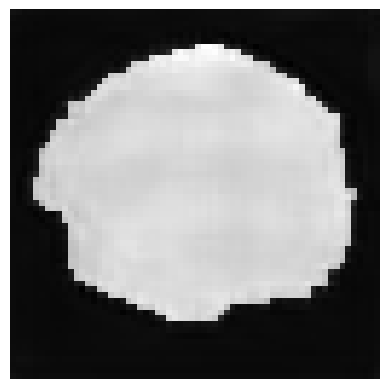

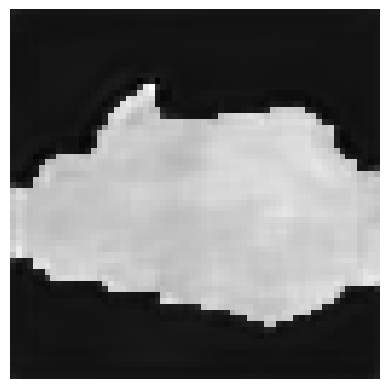

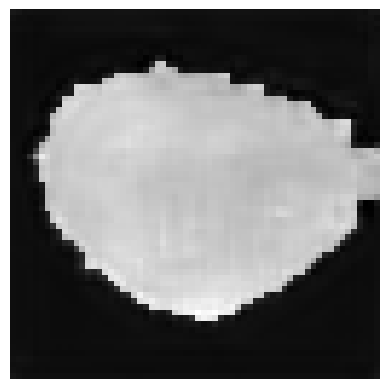

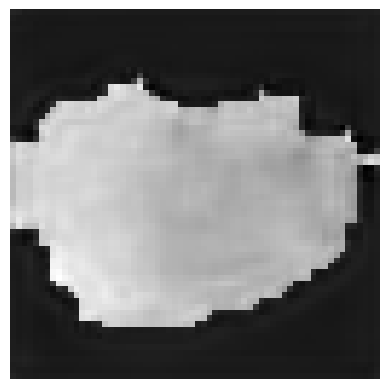

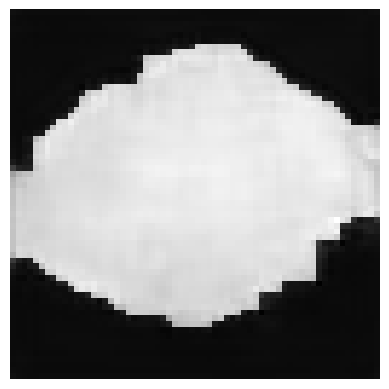

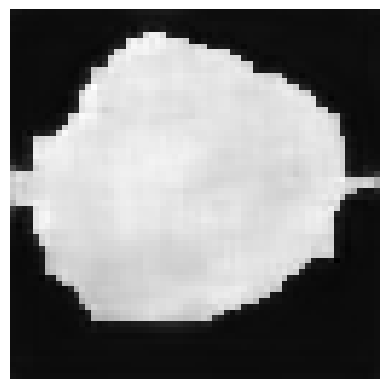

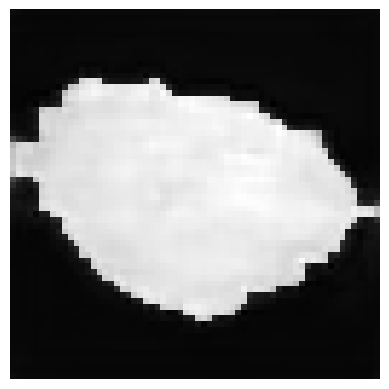

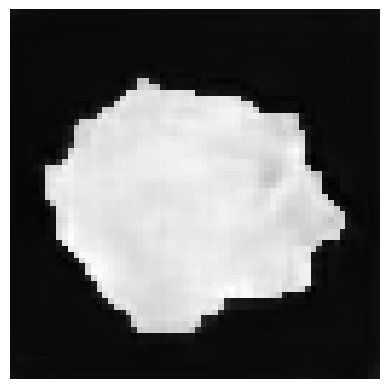

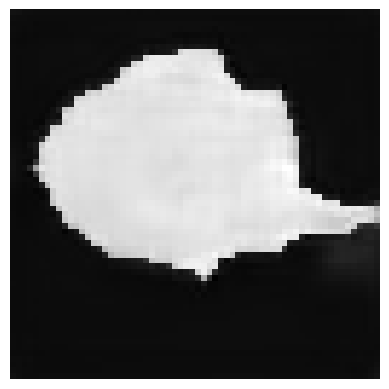

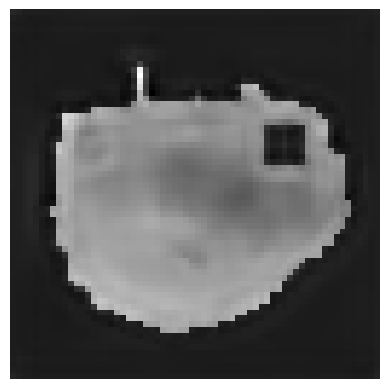

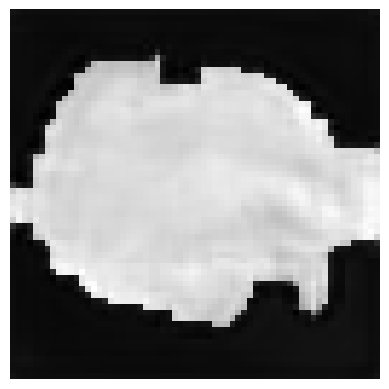

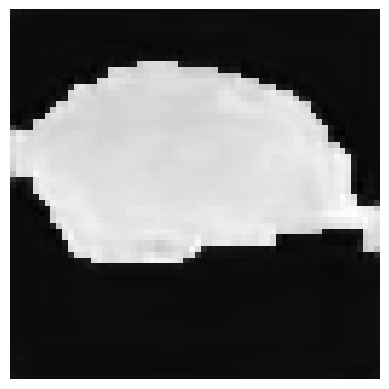

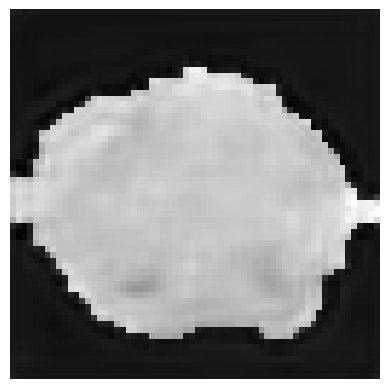

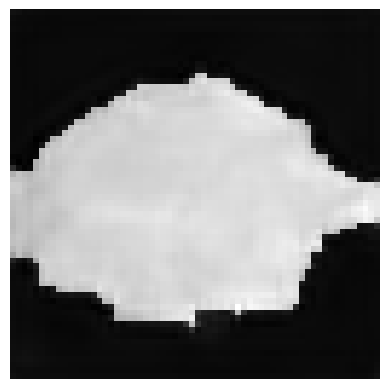

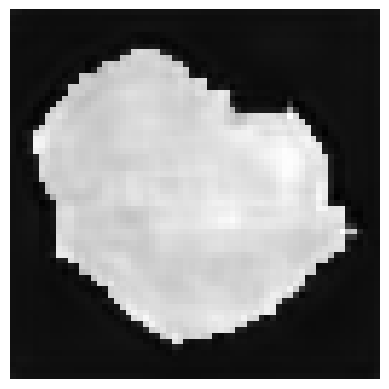

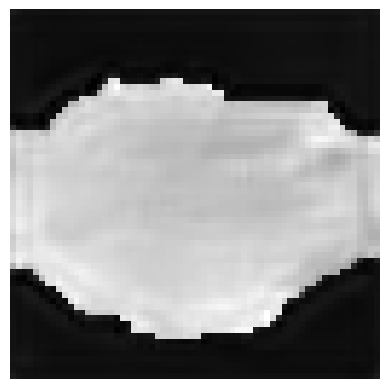

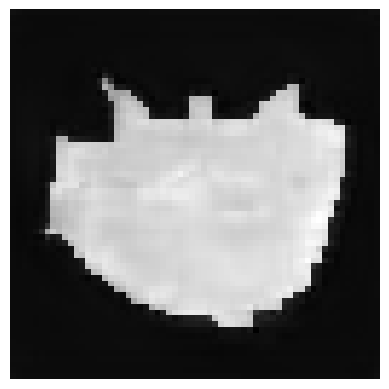

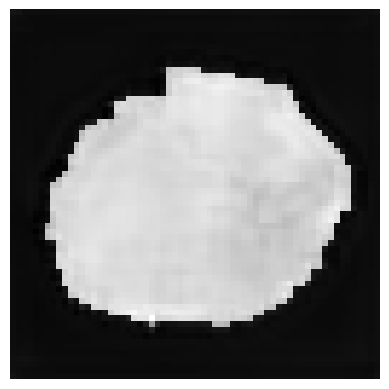

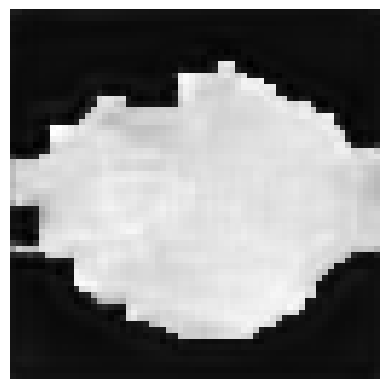

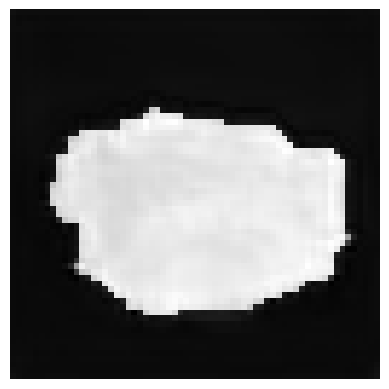

In [104]:
for i in raw_preds:
    plt.imshow(i[0][0], cmap="gray")
    plt.axis("off")
    plt.show()

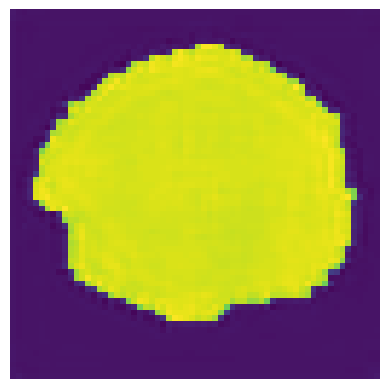

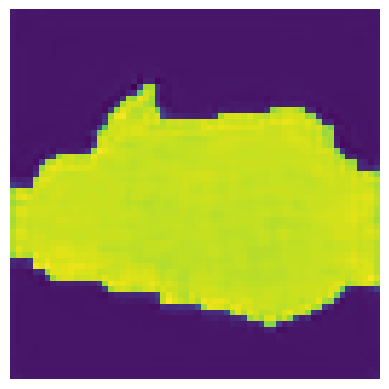

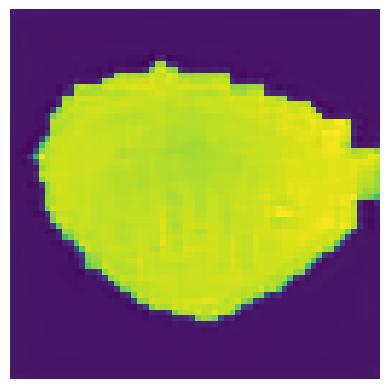

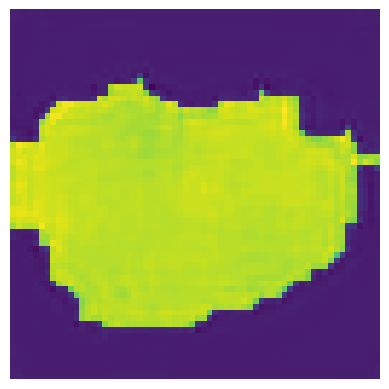

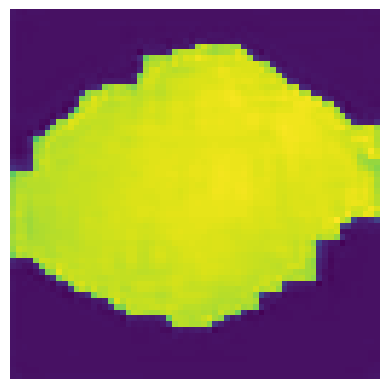

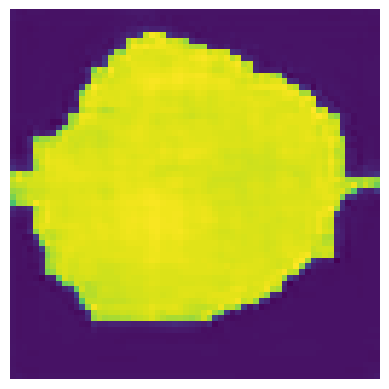

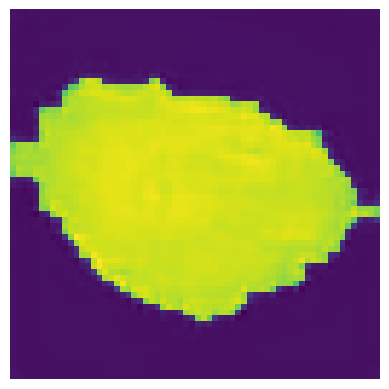

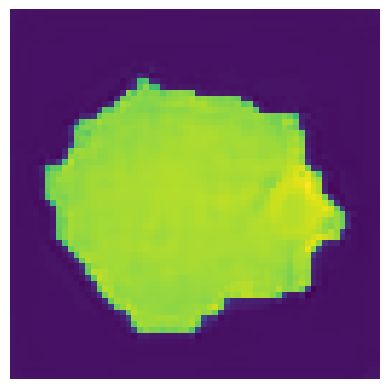

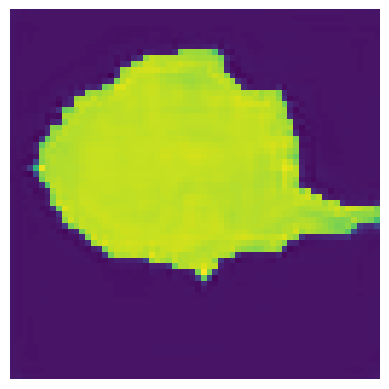

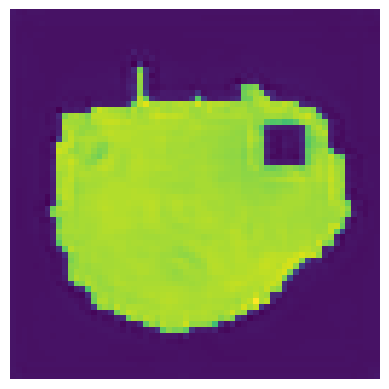

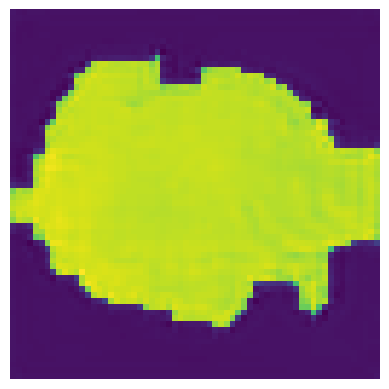

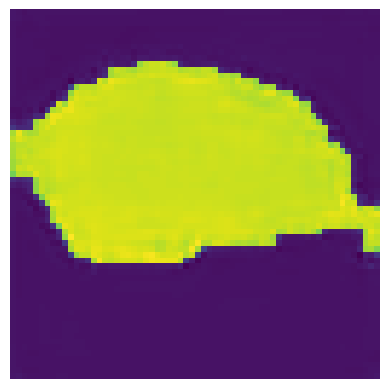

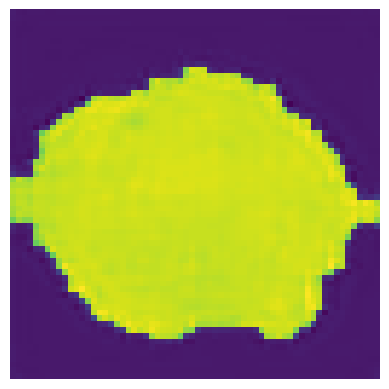

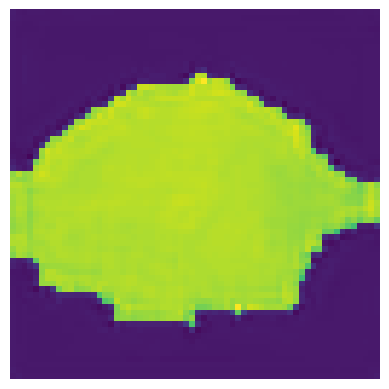

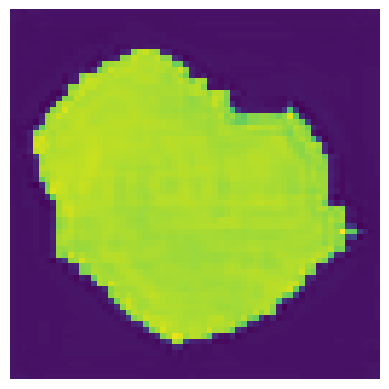

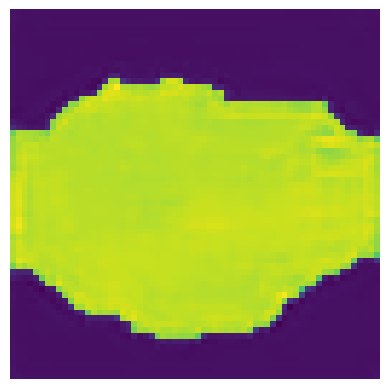

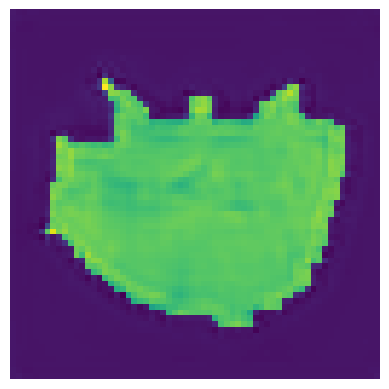

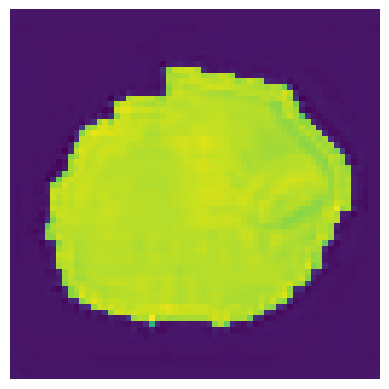

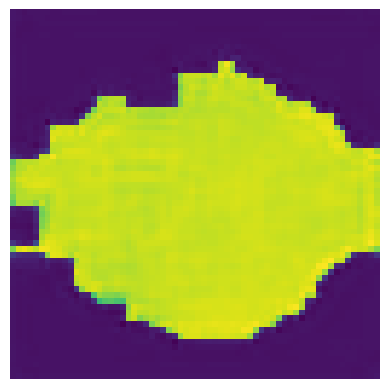

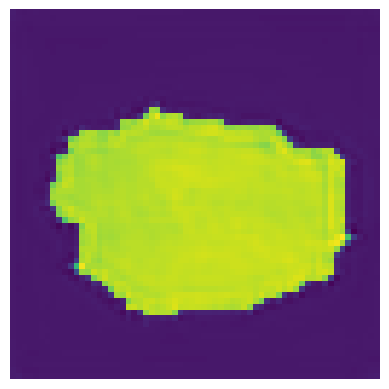

In [105]:
for i in raw_preds:
    plt.imshow(i[1][0])
    plt.axis("off")
    plt.show()